In [1]:
import os
import sys
import json
import random
import asyncio
import aiohttp
import pymupdf
import nest_asyncio
from pathlib import Path

from aiohttp import FormData
from dotenv import load_dotenv

In [2]:
project_root = Path.cwd().parent
sys.path.append(str(project_root))

load_dotenv(project_root / '.env')

True

In [3]:
GUIDELINE_PATH = "../resources/original/guideline.pdf"
API_SPEC_PATH = "../resources/original/api_specification.pdf"

SPLITTED_PDF_PATH = "../resources/processed/{}/splitted_pdfs"
ANALYZED_JSON_PATH = "../resources/processed/{}/analyzed_jsons"

In [4]:
BASE_DIR = Path.cwd().parent
RESOURCES_DIR = BASE_DIR / "resources"
ORIGINAL_DIR = RESOURCES_DIR / "original"
PROCESSED_DIR = RESOURCES_DIR / "processed"

def get_file_paths(doc_type):
    original_pdf = ORIGINAL_DIR / f"{doc_type}.pdf"
    processed_doc_dir = PROCESSED_DIR / doc_type
    return {
        "original_pdf": original_pdf,
        "splitted_pdfs": processed_doc_dir / "splitted_pdfs",
        "analyze_request_info": processed_doc_dir / "analyze_request_info.json",
        "analyzed_jsons": processed_doc_dir / "analyzed_jsons"
    }

GUIDELINE_PATHS = get_file_paths("guideline")
API_SPEC_PATHS = get_file_paths("api_specification")

print(f"GUIDELINE_PATHS: {GUIDELINE_PATHS}")
print(f"API_SPEC_PATHS: {API_SPEC_PATHS}")

GUIDELINE_PATHS: {'original_pdf': PosixPath('/Users/gabriela/src/workspace/rag-agent/resources/original/guideline.pdf'), 'splitted_pdfs': PosixPath('/Users/gabriela/src/workspace/rag-agent/resources/processed/guideline/splitted_pdfs'), 'analyze_request_info': PosixPath('/Users/gabriela/src/workspace/rag-agent/resources/processed/guideline/analyze_request_info.json'), 'analyzed_jsons': PosixPath('/Users/gabriela/src/workspace/rag-agent/resources/processed/guideline/analyzed_jsons')}
API_SPEC_PATHS: {'original_pdf': PosixPath('/Users/gabriela/src/workspace/rag-agent/resources/original/api_specification.pdf'), 'splitted_pdfs': PosixPath('/Users/gabriela/src/workspace/rag-agent/resources/processed/api_specification/splitted_pdfs'), 'analyze_request_info': PosixPath('/Users/gabriela/src/workspace/rag-agent/resources/processed/api_specification/analyze_request_info.json'), 'analyzed_jsons': PosixPath('/Users/gabriela/src/workspace/rag-agent/resources/processed/api_specification/analyzed_json

In [5]:
UPSTAGE_INFERENCE_URL = "https://ocr-demo.upstage.ai/api/layout-analysis/inference"
UPSTAGE_RESULT_BASE_URL = "https://ocr-demo.upstage.ai/api/result/"

In [6]:
upstage_api_headers = {"Accept": "*/*",
                       "origin": "https://d3tgkvf102zvh7.cloudfront.net",
                       "priority": "u=1, i",
                       "referer": "https://d3tgkvf102zvh7.cloudfront.net/",
                       "user-agent": "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/129.0.0.0 Safari/537.36"
                       }

In [7]:
from ingestion.nodes import pdf
from ingestion.nodes import layout
from ingestion.states import FileState
from langgraph.graph import END, StateGraph
from langgraph.checkpoint.memory import MemorySaver

init_pdf_node = pdf.InitPDFNode(file_paths=GUIDELINE_PATHS, verbose=True)
pdf_split_node = pdf.SplitPDFNode(batch_size=1, verbose=True)
layout_node = layout.LayoutNode(file_paths=GUIDELINE_PATHS, verbose=True)

workflow = StateGraph(FileState)

workflow.add_node("init_pdf_node", init_pdf_node)
workflow.add_node("pdf_split_node", pdf_split_node)
workflow.add_node("layout_node", layout_node)

workflow.add_edge("init_pdf_node", "pdf_split_node")
workflow.add_edge("pdf_split_node", "layout_node")

workflow.set_entry_point("init_pdf_node")

memory_saver = MemorySaver()
app = workflow.compile(checkpointer=memory_saver)

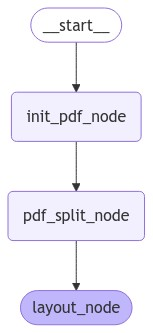

In [8]:
from IPython.display import Image, display

try:
    display(
        Image(app.get_graph(xray=True).draw_mermaid_png())
    )
except:
    pass

In [9]:
from langgraph.errors import GraphRecursionError
from langchain_core.runnables import RunnableConfig

config = RunnableConfig({"thread_id": "ingestion"})
inputs = FileState(file_paths=GUIDELINE_PATHS)

try:
    result = app.invoke(inputs, config=config)
except GraphRecursionError as e:
    print(f"Recursion limit reached: {e}")

2024-10-20 13:03:11,788 - ingestion - INFO - {
  "class": "InitPDFNode",
  "message": "InitPDFNode execution completed",
  "extra": {
    "file_basename": "guideline",
    "file_type": "pdf"
  }
}
2024-10-20 13:03:11,956 - ingestion - INFO - {
  "class": "SplitPDFNode",
  "message": "analyze_request_info file already exists: /Users/gabriela/src/workspace/rag-agent/resources/processed/guideline/analyze_request_info.json"
}
2024-10-20 13:03:11,957 - ingestion - INFO - {
  "class": "SplitPDFNode",
  "message": "SplitPDFNode execution completed",
  "extra": {
    "num_total_page": 136,
    "num_split_files": 136
  }
}
2024-10-20 13:03:11,959 - ingestion - INFO - {
  "class": "LayoutNode",
  "message": "LayoutNode execution completed",
  "extra": {
    "total_requests": 136,
    "sucessed_requests": 136,
    "succed_get_result_requests": 136
  }
}


In [15]:
result

{'file_paths': {'original_pdf': PosixPath('/Users/gabriela/src/workspace/rag-agent/resources/original/guideline.pdf'),
  'splitted_pdfs': PosixPath('/Users/gabriela/src/workspace/rag-agent/resources/processed/guideline/splitted_pdfs'),
  'analyze_request_info': PosixPath('/Users/gabriela/src/workspace/rag-agent/resources/processed/guideline/analyze_request_info.json'),
  'analyzed_jsons': PosixPath('/Users/gabriela/src/workspace/rag-agent/resources/processed/guideline/analyzed_jsons')},
 'file_basename': 'guideline',
 'file_type': 'pdf',
 'num_total_page': 136,
 'split_size': 1,
 'splitted_file_paths': ['/Users/gabriela/src/workspace/rag-agent/resources/processed/guideline/splitted_pdfs/guideline_000_000.pdf',
  '/Users/gabriela/src/workspace/rag-agent/resources/processed/guideline/splitted_pdfs/guideline_001_001.pdf',
  '/Users/gabriela/src/workspace/rag-agent/resources/processed/guideline/splitted_pdfs/guideline_002_002.pdf',
  '/Users/gabriela/src/workspace/rag-agent/resources/proce